In [1]:
import glob 
import random 
import dask.dataframe as dd
import matplotlib.pyplot as plt

In [2]:

state_vector_sample_files = glob.glob("../../julien_data/raw/state_vectors_samples/*.parquet")

# choose 3 random files
random_files = random.sample(state_vector_sample_files, 8)

# read the files
df = dd.read_parquet(random_files)

df.head()


icao24        time        lat        lon    velocity     heading  vertrate  \
0  aaa573  1706577659  31.256941 -83.060706  292.684277  154.380784 -24.70912   
1  a0ed6e  1706577659  34.202115 -81.699886   176.13604  278.059104   4.22656   
2  a3b4e9  1706577659   33.97387 -84.221821   115.76819  271.018484       0.0   
3  a46e40  1706577659  34.182843 -83.741226  173.837167  221.520891   -6.5024   
4  ad6f52  1706577659  34.954772 -81.027832    58.10485  200.199807       0.0   

   callsign onground    spi squawk  geoaltitude  baroaltitude  
0  SWA732      False  False   <NA>      11468.1      11186.16  
1  UPS9744     False  False   <NA>      4518.66       4541.52  
2  LBQ840      False  False   <NA>      1805.94       1775.46  
3  DAL2842     False  False   <NA>      3992.88        3924.3  
4  N965GC      False  False   <NA>        952.5        967.74

In [3]:
df_pandas = df.compute()  # Convert Dask DataFrame to pandas DataFrame


In [4]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5195425 entries, 0 to 1116709
Data columns (total 13 columns):
 #   Column        Dtype          
---  ------        -----          
 0   icao24        string         
 1   time          int64[pyarrow] 
 2   lat           double[pyarrow]
 3   lon           double[pyarrow]
 4   velocity      double[pyarrow]
 5   heading       double[pyarrow]
 6   vertrate      double[pyarrow]
 7   callsign      string         
 8   onground      bool[pyarrow]  
 9   spi           bool[pyarrow]  
 10  squawk        string         
 11  geoaltitude   double[pyarrow]
 12  baroaltitude  double[pyarrow]
dtypes: bool[pyarrow](2), double[pyarrow](7), int64[pyarrow](1), string(3)
memory usage: 558.2 MB


Flight 000001 has 559 positions


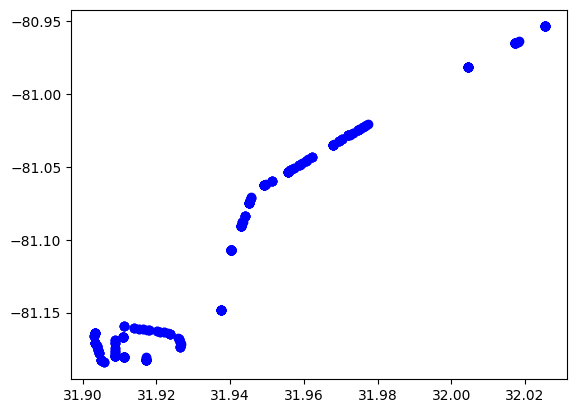

In [6]:
# Method 3: If you want to perform operations on each group
for icao24, flight_data in df_pandas.groupby('icao24'):
    print(f"Flight {icao24} has {len(flight_data)} positions")
    
    # Split data into onground and not onground
    onground_data = flight_data[flight_data['onground']]
    airborne_data = flight_data[~flight_data['onground']]
    
    # Plot onground points in red and airborne points in blue
    plt.scatter(onground_data['lat'], onground_data['lon'], c='red', label=f'Flight {icao24} (on ground)')
    plt.scatter(airborne_data['lat'], airborne_data['lon'], c='blue', label=f'Flight {icao24} (airborne)')
    
    break
    # Do something with flight_data

In [5]:
df.shape[0].compute()

2400608

icao24                0
time                  0
lat                   0
lon                   0
velocity           8372
heading            8372
vertrate           8281
callsign          19025
onground              0
spi                   0
squawk          1427501
geoaltitude       23222
baroaltitude      19890
dtype: int64


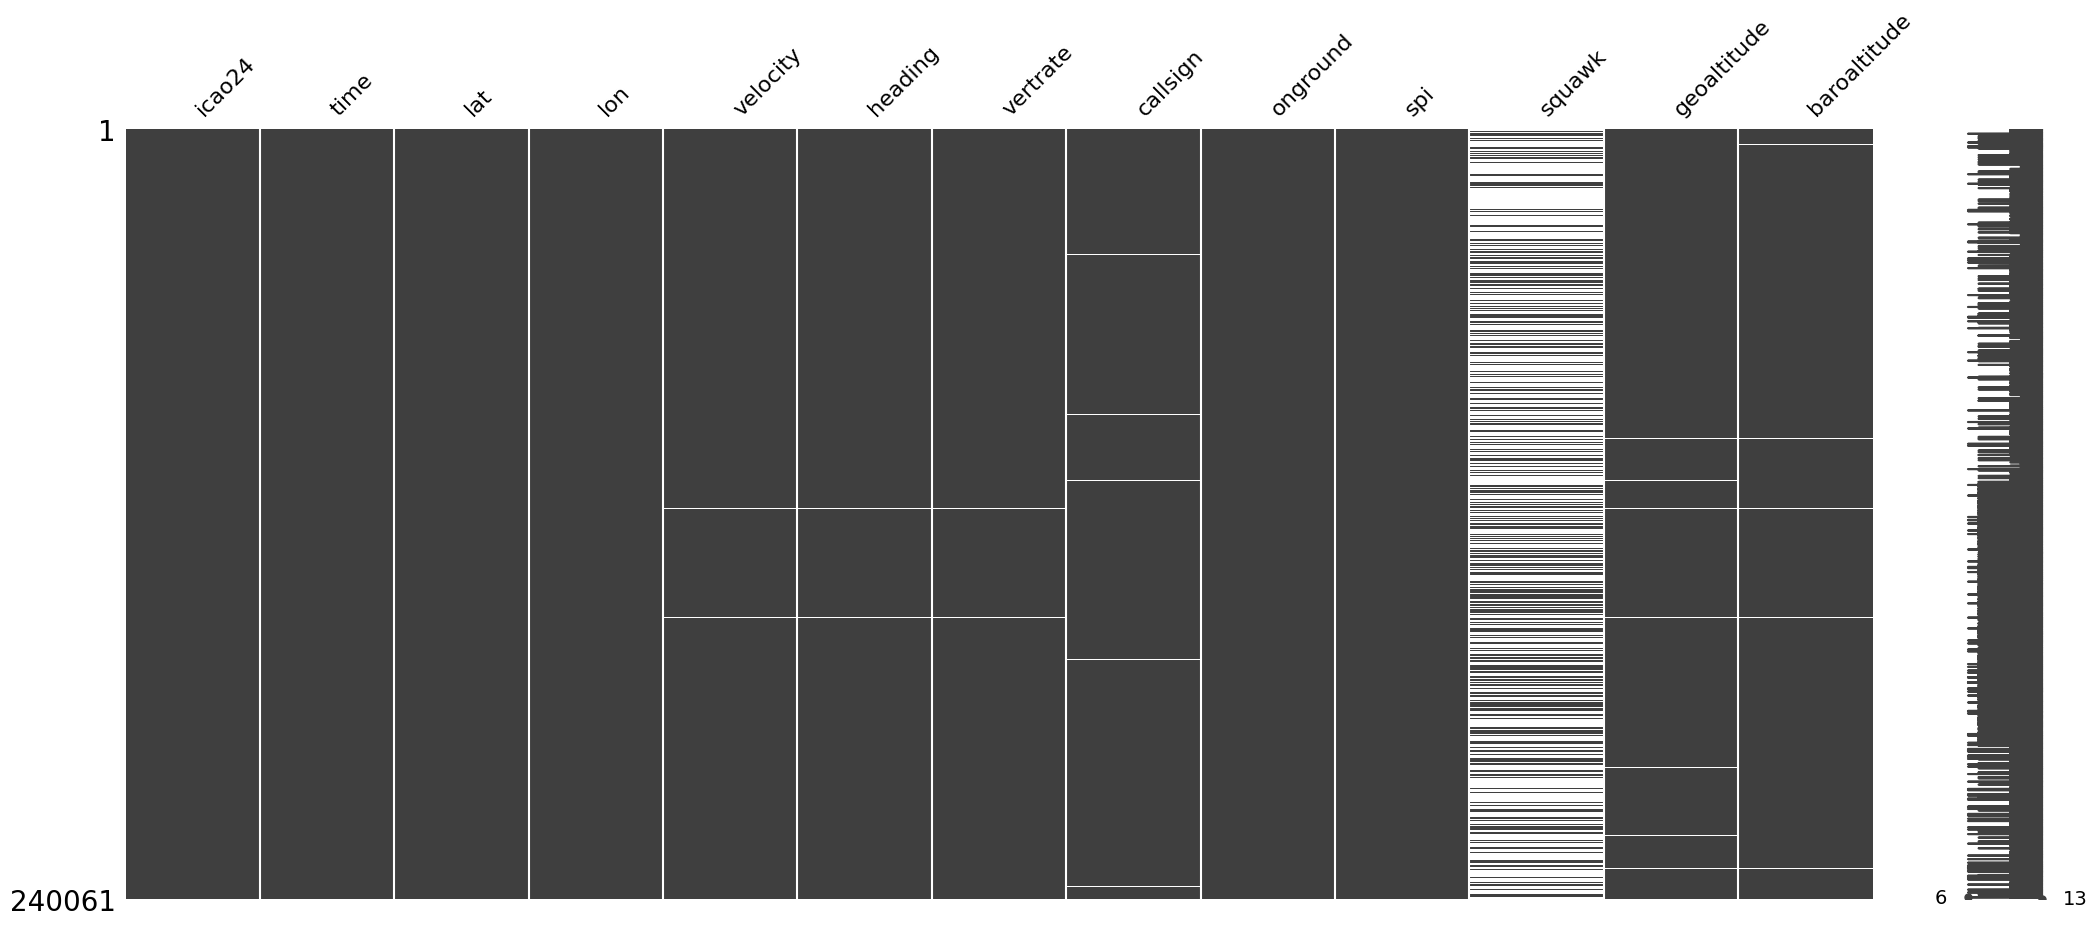

In [6]:
# missing analysis
import missingno as msno

# Convert a sample of the Dask DataFrame to pandas
# Adjust the sample size (0.1 = 10%) based on your data size and memory constraints
pandas_df = df.sample(frac=.10).compute()  # or use frac=0.1 for percentage-based sampling

# Now use missingno with the pandas DataFrame
msno.matrix(pandas_df)

# For missing values count, you can still use the full Dask DataFrame
missing_counts = df.isnull().sum().compute()
print(missing_counts)

We can drop squawk column and for velocity, heading, vertrate, callsign, geoaltitude, and baroaltitude we can impute with KNNImputer

In [5]:
from sklearn.impute import KNNImputer

# drop squawk column
df = df.drop(columns=['squawk'])

def impute_partition(pdf):
    imputer = KNNImputer(n_neighbors=5)
    # Impute the selected numeric columns in this Pandas partition
    pdf[['velocity', 'heading', 'vertrate', 'geoaltitude', 'baroaltitude']] = imputer.fit_transform(pdf[['velocity', 'heading', 'vertrate', 'geoaltitude', 'baroaltitude']])
    return pdf

# Apply the imputation to each partition
df = df.map_partitions(impute_partition)
df.head()

icao24        time        lat        lon    velocity     heading  vertrate  \
0  a3b88e  1719439014   33.26825 -84.427789  244.901821  179.157476   0.00000   
1  a4a377  1719439014  34.110407 -83.809776   69.144412  342.239088  -5.85216   
2  a46e0f  1719439014  34.558548  -84.90509   91.058041   52.806401   0.00000   
3  a06f22  1719439014  33.621689  -83.77277  255.960577   48.911572  -8.12800   
4  aa79f6  1719439014  34.444094 -83.451004  201.964320  223.451842  -9.42848   

   callsign onground    spi  geoaltitude  baroaltitude  
0  AAL1511     False  False      9997.44       9448.80  
1  N3984T      False  False      1470.66       1463.04  
2  N385C       False  False      3512.82       3360.42  
3  EJA127      False  False      7520.94       6926.58  
4  AAL1992     False  False      6111.24       5783.58

In [6]:
missing_counts = df.isnull().sum().compute()
print(missing_counts)

: 

## Georgia Data Analysis

Over interval of 12 hours over Georgia Bounds

In [2]:
import dask.dataframe as dd

df = dd.read_parquet("../../data/georgia_data_2/georgia_complete_dataset.parquet")
df.head(10)


time  icao24 callsign   latitude  longitude  altitude  \
0  2025-01-24 03:34:54+00:00  ad67ae     <NA>  33.646747 -84.437313      <NA>   
1  2025-01-24 03:34:55+00:00  ad67ae     <NA>  33.646729 -84.438115    426.72   
2  2025-01-24 03:34:56+00:00  ad67ae     <NA>  33.646683 -84.439068     457.2   
3  2025-01-24 03:34:57+00:00  ad67ae     <NA>  33.646701 -84.439888    464.82   
4  2025-01-24 03:34:58+00:00  ad67ae  DAL3153  33.646637  -84.44103    487.68   
5  2025-01-24 03:34:59+00:00  ad67ae  DAL3153  33.646607 -84.441833    510.54   
6  2025-01-24 03:35:00+00:00  ad67ae  DAL3153  33.646607 -84.442463    518.16   
7  2025-01-24 03:35:01+00:00  ad67ae  DAL3153  33.646545 -84.443777    525.78   
8  2025-01-24 03:35:02+00:00  ad67ae  DAL3153  33.646514 -84.444237     533.4   
9  2025-01-24 03:35:03+00:00  ad67ae  DAL3153  33.646468  -84.44521     571.5   

    velocity     heading  vertrate onground  
0  82.839862    268.9325  17.23136    False  
1  82.851042  268.576795  17.23136    False  
2  82.351221  268.210089  16.90624    False  
3  82.368895  267.852415  16.58112    False  
4  82.389777  267.494907    16.256    False  
5  81.875827  267.479172  15.93088    False  
6  81.900066  267.119622  15.60576    False  
7  81.900066  267.119622  15.28064    False  
8  81.900066  267.119622  14.95552    False  
9  81.958211  266.401232   14.6304    False

In [3]:
df.info()

<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 10 entries, time to onground
dtypes: bool[pyarrow](1), double[pyarrow](6), string(2), timestamp[ns, tz=UTC][pyarrow](1)

In [5]:
num_rows = df.shape[0].compute()
print(f"Number of rows: {num_rows}")


Number of rows: 48243364


In [5]:
# compute the number of unique values in icao24
unique_icao24 = df['icao24'].nunique().compute()
print(f"Number of unique icao24: {unique_icao24}")

# compute the number of unique values in callsign
unique_callsign = df['callsign'].nunique().compute()
print(f"Number of unique callsign: {unique_callsign}")


Number of unique icao24: 8614
Number of unique callsign: 11934


In [6]:
# how many unique icao24 and callsign combinations
df.groupby('icao24').size().compute()

icao24
04004c    3133
06804e    1569
06a123    7025
06a129    5133
0aa918     497
          ... 
cae20f     624
e4809f     444
e49d87    2260
e80212    6668
e80244    3723
Length: 8614, dtype: int64

In [4]:
# group by icao24 and callsign and agggregate latitude	longitude	altitude	velocity	heading	vertrate
flights_df = df.groupby(['icao24', 'callsign']).agg({'latitude': 'mean', 'longitude': 'mean', 'altitude': 'mean', 'velocity': 'mean', 'heading': 'mean', 'vertrate': 'mean'}).sample(frac=0.01).compute()

flights_df.head()

latitude  longitude      altitude    velocity     heading  \
icao24 callsign                                                               
a87c12 FFT3955   32.471794 -81.478927  11857.120488  203.283372  196.221136   
ab15c1 AAY1239   31.876884 -81.083961  11620.887215  177.640601  188.897428   
a379d3 DAL798    33.641882  -84.43315          <NA>        <NA>        <NA>   
a086ce EDV5532   33.651916 -84.481403    3061.25483  137.428518  283.178827   
a54c9f TCN440    34.165028  -83.27917  11333.922806  171.496294  242.093612   

                  vertrate  
icao24 callsign             
a87c12 FFT3955   -0.011742  
ab15c1 AAY1239    -1.33289  
a379d3 DAL798         <NA>  
a086ce EDV5532   11.072975  
a54c9f TCN440     3.042226

In [5]:
flights_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 189 entries, ('a87c12', 'FFT3955') to ('a2b759', 'SWA1629')
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype          
---  ------     --------------  -----          
 0   latitude   189 non-null    double[pyarrow]
 1   longitude  189 non-null    double[pyarrow]
 2   altitude   188 non-null    double[pyarrow]
 3   velocity   188 non-null    double[pyarrow]
 4   heading    188 non-null    double[pyarrow]
 5   vertrate   188 non-null    double[pyarrow]
dtypes: double[pyarrow](6)
memory usage: 294.6+ KB


In [2]:

# Convert time column to datetime if not already
df['time'] = dd.to_datetime(df['time']).astype('datetime64[ns]')
df = df.set_index('time')

# Resample using Dask
resampled_df = df.resample('1T').agg({
    'icao24': 'first',
    'callsign': 'last',
    'latitude': 'last',
    'longitude': 'last',
    'altitude': 'mean',
    'velocity': 'mean',
    'heading': 'mean',
    'vertrate': 'mean',
    'onground': 'last'
}).reset_index()

# Compute the result and check the size reduction
original_size = df.shape[0].compute()
resampled_size = resampled_df.shape[0].compute()
compression_ratio = original_size / resampled_size

print(f"Original rows: {original_size:,}")
print(f"Resampled rows: {resampled_size:,}")
print(f"Compression ratio: {compression_ratio:.2f}x")

# Save the resampled data if desired
resampled_df.to_parquet("../../data/georgia_data_2/georgia_resampled_1min.parquet")

: 

## Looking at single flight's state vector from accident flights

In [13]:
import pandas as pd

single_accident_df = pd.read_parquet("/home/jhovan/GitHub/Aviation-Milestone2-Project/data/processed/state_vectors_a010b3_1706462040_1706467389.parquet")

In [14]:
single_accident_df

icao24        time        lat         lon    velocity     heading  \
0     a010b3  1706462041   39.79518 -106.772827  147.490296   85.999814   
1     a010b3  1706462042  39.795273 -106.771287  147.490296   85.999814   
2     a010b3  1706462043  39.795273 -106.771287  148.040144   85.815084   
3     a010b3  1706462044  39.795273 -106.771287  148.040144   85.815084   
4     a010b3  1706462045  39.795456 -106.767824  148.553221   85.829563   
...      ...         ...        ...         ...         ...         ...   
5296  a010b3  1706467385  35.396692  -94.286129  120.789216  104.805665   
5297  a010b3  1706467386  35.396393  -94.284897  121.070436  107.049031   
5298  a010b3  1706467387  35.396393  -94.284897  121.070436  107.049031   
5299  a010b3  1706467388  35.396393  -94.284897  121.070436  107.049031   
5300  a010b3  1706467389  35.395296  -94.281512  121.070436  107.049031   

      vertrate  callsign onground    spi squawk  geoaltitude  baroaltitude  
0      8.77824      <NA>    False  False   <NA>         <NA>       7551.42  
1      8.77824      <NA>    False  False   <NA>         <NA>       7559.04  
2      8.77824      <NA>    False  False   <NA>      7818.12       7559.04  
3      8.77824      <NA>    False  False   <NA>      7818.12       7559.04  
4      8.77824      <NA>    False  False   <NA>      7833.36       7574.28  
...        ...       ...      ...    ...    ...          ...           ...  
5296 -10.40384  TMB103      False  False   <NA>       1066.8         952.5  
5297 -10.40384  TMB103      False  False   <NA>      1013.46        944.88  
5298 -10.40384  TMB103      False  False   <NA>      1013.46        944.88  
5299 -10.40384  TMB103      False  False   <NA>      1013.46        944.88  
5300 -10.40384  TMB103      False  False   <NA>      1013.46         914.4  

[5301 rows x 13 columns]

In [15]:
# Ensure latitude and longitude are numeric
single_accident_df['lat'] = pd.to_numeric(single_accident_df['lat'], errors='coerce')
single_accident_df['lon'] = pd.to_numeric(single_accident_df['lon'], errors='coerce')

# Filter out any rows with missing coordinate data
flight_data = single_accident_df.dropna(subset=['lat', 'lon'])

In [35]:
import folium
from datetime import datetime
import pytz
import matplotlib.cm as cm
import matplotlib.colors as colors
from branca.colormap import LinearColormap

# Extract the coordinates as a list of [lat, lon] pairs
coordinates = flight_data[['lat', 'lon']].values.tolist()
if not coordinates:
    raise ValueError("No valid latitude and longitude data available for plotting.")

# Create a folium map centered on the starting point
start_location = coordinates[0]
map_flight = folium.Map(location=start_location, zoom_start=10)

# Normalize altitude data for color mapping
altitudes = flight_data['baroaltitude']
norm = colors.Normalize(vmin=altitudes.min(), vmax=altitudes.max())
color_map = cm.ScalarMappable(norm=norm, cmap='viridis')

# Create individual line segments with altitude-based colors
for i in range(len(coordinates)-1):
    segment = [coordinates[i], coordinates[i+1]]
    altitude = (altitudes.iloc[i] + altitudes.iloc[i+1])/2  # Average between points
    hex_color = colors.to_hex(color_map.to_rgba(altitude))
    
    folium.PolyLine(
        segment,
        color=hex_color,
        weight=3,
        opacity=0.8
    ).add_to(map_flight)

# Add color scale legend to the map
LinearColormap(
    colors=['#440154', '#3b528b', '#21918c', '#5ec962', '#fde725'],
    index=[0, 0.25, 0.5, 0.75, 1],
    caption='Barometric Altitude (meters)',
    vmin=altitudes.min(),
    vmax=altitudes.max()
).add_to(map_flight)

# Convert accident time string to timestamp
accident_time = datetime.strptime("2024-01-28 18:23:00+00:00", "%Y-%m-%d %H:%M:%S%z")
accident_ts = int(accident_time.timestamp())

# Find the closest point in time to the accident
flight_data['time_diff'] = abs(flight_data['time'] - accident_ts)
accident_point = flight_data.loc[flight_data['time_diff'].idxmin()]

# Add markers for start, end and accident points
folium.Marker(
    location=coordinates[0],
    popup="Start",
    icon=folium.Icon(color="green")
).add_to(map_flight)

folium.Marker(
    location=coordinates[-1],
    popup="End",
    icon=folium.Icon(color="red")
).add_to(map_flight)

folium.Marker(
    location=[accident_point['lat'], accident_point['lon']],
    popup="Accident",
    icon=folium.Icon(color="black")
).add_to(map_flight)

# Display the map
map_flight

In [20]:
def resample_flight_state_data(df, interval='5s'):
    """
    Resample flight data at specified time intervals.
    
    Args:
        df: DataFrame containing flight data with a 'time' column
        interval: String specifying the resampling interval (default '5S' for 5 seconds)
        
    Returns:
        Resampled DataFrame
    """
    # Work on a copy of the dataframe
    df_copy = df.copy()
    
    # Convert the 'time' column to datetime
    df_copy['time'] = pd.to_datetime(df_copy['time'], unit='s')
    
    # Sort by time
    df_copy = df_copy.sort_values('time')
    
    # Set time as index
    df_copy.set_index('time', inplace=True)
    
    # Resample and take first record in each interval
    resampled_df = df_copy.resample(interval).first().reset_index()
    
    return resampled_df

# Test the function
resampled_df = resample_flight_state_data(single_accident_df)
resampled_df.head()

time  icao24        lat         lon    velocity    heading  \
0 2024-01-28 17:14:00  a010b3   39.79518 -106.772827  147.490296  85.999814   
1 2024-01-28 17:14:05  a010b3  39.795456 -106.767824  148.553221  85.829563   
2 2024-01-28 17:14:10  a010b3  39.795646 -106.764221  149.579403  85.858225   
3 2024-01-28 17:14:15  a010b3  39.795646 -106.764221  151.118746  85.900487   
4 2024-01-28 17:14:20  a010b3  39.796856 -106.742981  152.658169  85.941896   

   vertrate  callsign onground    spi squawk  geoaltitude  baroaltitude  
0   8.77824      <NA>    False  False   <NA>      7818.12       7551.42  
1   8.77824      <NA>    False  False   <NA>      7833.36       7574.28  
2   8.77824      <NA>    False  False   <NA>       7848.6       7589.52  
3   8.77824  TMB103      False  False   <NA>       7848.6       7589.52  
4   8.77824  TMB103      False  False   <NA>       7962.9       7703.82

In [22]:
resampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   time          1070 non-null   datetime64[ns] 
 1   icao24        1061 non-null   string         
 2   lat           1061 non-null   double[pyarrow]
 3   lon           1061 non-null   double[pyarrow]
 4   velocity      1060 non-null   double[pyarrow]
 5   heading       1060 non-null   double[pyarrow]
 6   vertrate      1060 non-null   double[pyarrow]
 7   callsign      1053 non-null   string         
 8   onground      1061 non-null   bool[pyarrow]  
 9   spi           1061 non-null   bool[pyarrow]  
 10  squawk        495 non-null    string         
 11  geoaltitude   1060 non-null   double[pyarrow]
 12  baroaltitude  1061 non-null   double[pyarrow]
dtypes: bool[pyarrow](2), datetime64[ns](1), double[pyarrow](7), string(3)
memory usage: 110.3 KB


In [1]:
import pandas as pd

state_processed_df = pd.read_parquet("../../data/processed/enid_data/processed_state_vectors_chunk_2.parquet")
state_processed_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21308111 entries, 0 to 21308110
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   icao24       object 
 1   lat          float64
 2   lon          float64
 3   velocity     float64
 4   vertrate     float64
 5   heading      float64
 6   geoaltitude  float64
dtypes: float64(6), object(1)
memory usage: 1.1+ GB


In [4]:
state_processed_df.head()

icao24        lat        lon   velocity  vertrate     heading  geoaltitude
0  a3a630  34.666214 -82.903953  52.083485   7.80288  249.775141       403.86
1  a3a630  34.666214 -82.903953  52.083485   7.80288  249.775141       403.86
2  a3a630  34.666214 -82.903953  52.083485   7.80288  249.775141       403.86
3  a3a630  34.666214 -82.903953  52.083485   7.80288  249.775141       403.86
4  a3a630  34.666214 -82.903953  52.083485   7.80288  249.775141       403.86

In [2]:
state_processed_df.isna().sum()

icao24         0
lat            0
lon            0
velocity       0
vertrate       0
heading        0
geoaltitude    0
dtype: int64

In [3]:
# find number of flights by grouping on icao24
state_processed_df.groupby('icao24').size()

icao24
000001    2600
040046    3361
06a121    1378
06a127    1463
06a12b    1680
          ... 
e4a002     250
e8021d    1835
e80242    1115
e90061     301
e90081     821
Length: 7279, dtype: int64

Top 3 flights by number of positions:
icao24
a02a0d    38572
a95fe6    37319
ac3110    27332
dtype: int64
Flight a02a0d has 38572 positions
Flight a95fe6 has 37319 positions
Flight ac3110 has 27332 positions


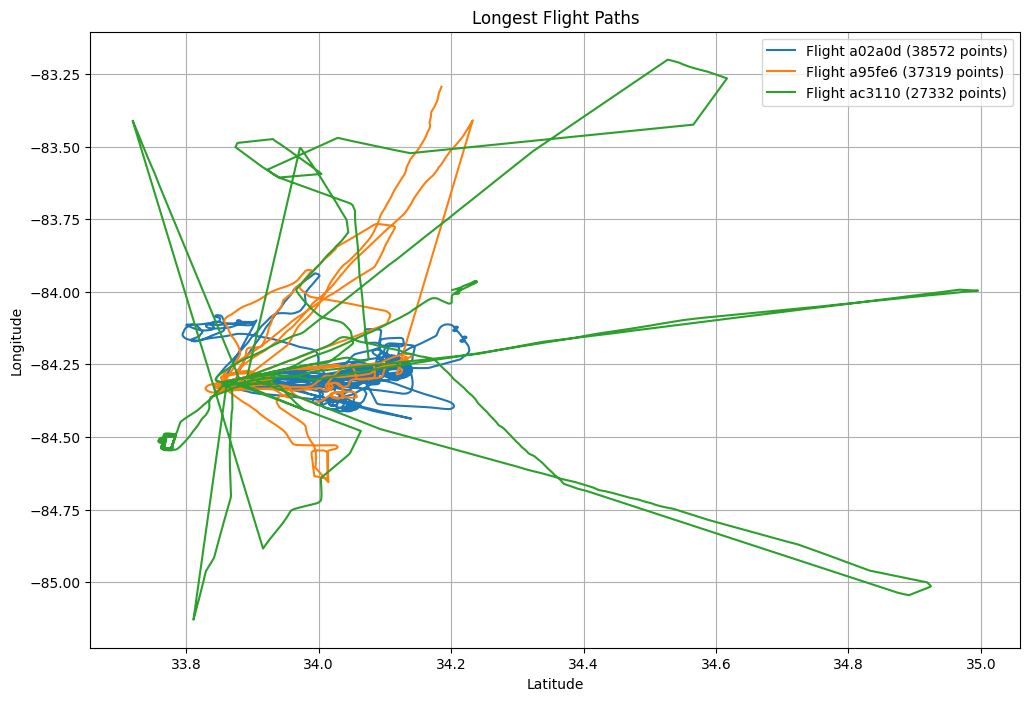

In [4]:
import matplotlib.pyplot as plt

# Get flight sizes and sort them in descending order
flight_sizes = state_processed_df.groupby('icao24').size().sort_values(ascending=False)
print("Top 3 flights by number of positions:")
print(flight_sizes.head(3))

plt.figure(figsize=(12, 8))
for i, (icao24, size) in enumerate(flight_sizes.items()):
    if i >= 3:  # Stop after 3 flights
        break
    flight_data = state_processed_df[state_processed_df['icao24'] == icao24]
    print(f"Flight {icao24} has {len(flight_data)} positions")
    plt.plot(flight_data['lat'], flight_data['lon'], label=f'Flight {icao24} ({size} points)')

plt.title('Longest Flight Paths')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()
plt.grid(True)
plt.show()